In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Visualizations

In [6]:
def visulaize_data(url, data_name):
    # Load data
    df = pd.read_csv(url)
    
    # Convert Date to datetime and create datetime index
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    df['datetime'] = df['Date'] + pd.to_timedelta(df['HE'] - 1, unit='h')
    df.set_index('datetime', inplace=True)
    
    
    # Create time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{data_name} Electricity Market Analysis: Peak vs Off-Peak Patterns', fontsize=16, fontweight='bold')
    
    # 1. FIXED: Price comparison - create data properly for boxplot
    price_data = []
    labels = []
    
    for peak_status in [0, 1]:
        subset = df[df['P/OP'] == peak_status]
        price_data.extend(subset['RT Busbar'].values)
        labels.extend([f'{"Peak" if peak_status == 1 else "Off-Peak"} RT'] * len(subset))
        
        price_data.extend(subset['DA Busbar'].values)
        labels.extend([f'{"Peak" if peak_status == 1 else "Off-Peak"} DA'] * len(subset))
    
    # Create DataFrame for boxplot
    boxplot_df = pd.DataFrame({
        'Price': price_data,
        'Category': labels
    })
    
    # Filter out any infinite or extreme values for better visualization
    boxplot_df = boxplot_df[np.isfinite(boxplot_df['Price'])]
    boxplot_df = boxplot_df[boxplot_df['Price'] < boxplot_df['Price'].quantile(0.99)]  # Remove extreme outliers
    
    sns.boxplot(data=boxplot_df, x='Category', y='Price', ax=axes[0,0])
    axes[0,0].set_title('Price Distribution: Peak vs Off-Peak')
    axes[0,0].set_ylabel('Price ($/MWh)')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Daily price patterns by hour
    hourly_avg = df.groupby(['hour', 'P/OP']).agg({
        'RT Busbar': 'mean',
        'DA Busbar': 'mean',
        'Gen': 'mean'
    }).reset_index()
    
    for peak_status in [0, 1]:
        subset = hourly_avg[hourly_avg['P/OP'] == peak_status]
        label = 'Peak' if peak_status == 1 else 'Off-Peak'
        axes[0,1].plot(subset['hour'], subset['RT Busbar'], 
                      marker='o', linewidth=2, label=f'{label} RT Price')
        axes[0,1].plot(subset['hour'], subset['DA Busbar'], 
                      marker='s', linestyle='--', linewidth=2, label=f'{label} DA Price')
    
    axes[0,1].set_title('Daily Price Patterns by Hour')
    axes[0,1].set_xlabel('Hour of Day')
    axes[0,1].set_ylabel('Average Price ($/MWh)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Generation patterns
    hourly_gen = df.groupby(['hour', 'P/OP'])['Gen'].mean().unstack()
    hourly_gen.columns = ['Off-Peak Generation', 'Peak Generation']
    hourly_gen.plot(ax=axes[0,2], linewidth=2, marker='o')
    axes[0,2].set_title('Average Generation by Hour')
    axes[0,2].set_xlabel('Hour of Day')
    axes[0,2].set_ylabel('Generation (MWh)')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Price volatility comparison
    volatility_data = []
    volatility_labels = []
    
    for peak_status in [0, 1]:
        subset = df[df['P/OP'] == peak_status]
        label = 'Peak' if peak_status == 1 else 'Off-Peak'
        volatility_data.append(subset['RT Busbar'].std())
        volatility_labels.append(label)
    
    axes[1,0].bar(volatility_labels, volatility_data, color=['skyblue', 'salmon'], alpha=0.7)
    axes[1,0].set_title('Price Volatility: Peak vs Off-Peak')
    axes[1,0].set_ylabel('Standard Deviation of RT Price')
    
    # Add value labels on bars
    for i, v in enumerate(volatility_data):
        axes[1,0].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')
    
    # 5. DA vs RT price correlation by peak status
    for peak_status in [0, 1]:
        subset = df[df['P/OP'] == peak_status].sample(n=min(1000, len(df[df['P/OP'] == peak_status])), random_state=42)
        label = 'Peak' if peak_status == 1 else 'Off-Peak'
        axes[1,1].scatter(subset['DA Busbar'], subset['RT Busbar'], 
                         alpha=0.6, label=label, s=20)
    
    # Add perfect prediction line
    max_price = max(df['DA Busbar'].max(), df['RT Busbar'].max())
    axes[1,1].plot([0, max_price], [0, max_price], 'k--', alpha=0.5, label='Perfect Prediction')
    axes[1,1].set_title('DA vs RT Price Correlation')
    axes[1,1].set_xlabel('Day-Ahead Price ($/MWh)')
    axes[1,1].set_ylabel('Real-Time Price ($/MWh)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Peak hour distribution by day of week
    peak_by_dow = df.groupby('day_of_week')['P/OP'].mean() * 100  # Percentage of peak hours
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[1,2].bar(days, peak_by_dow, color='lightcoral', alpha=0.7)
    axes[1,2].set_title('Percentage of Peak Hours by Day of Week')
    axes[1,2].set_ylabel('Peak Hours (%)')
    axes[1,2].set_ylim(0, 100)
    
    # Add value labels
    for i, v in enumerate(peak_by_dow):
        axes[1,2].text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # SUMMARY STATISTICS
    print("\n" + "="*60)
    print("SUMMARY STATISTICS: PEAK VS OFF-PEAK ANALYSIS")
    print("="*60)
    
    # Peak/Off-Peak specific analysis
    print(f"\nPeak vs Off-Peak Summary Statistics:")
    print("-"*60)
    summary_stats = df.groupby('P/OP').agg({
        'RT Busbar': ['mean', 'std', 'min', 'max'],
        'DA Busbar': ['mean', 'std'],
        'Gen': 'mean'
    }).round(2)
    
    print(summary_stats)
    
    # Arbitrage opportunity analysis
    df['price_spread'] = df['RT Busbar'] - df['DA Busbar']
    arbitrage_by_peak = df.groupby('P/OP')['price_spread'].agg(['mean', 'std']).round(2)
    print(f"\n\nArbitrage Opportunities (RT - DA Spread):")
    print("-"*60)
    print(arbitrage_by_peak)
    
    # Peak hour analysis
    print(f"\n\nPeak Hour Analysis:")
    print("-"*60)
    peak_hours = df[df['P/OP'] == 1]
    off_peak_hours = df[df['P/OP'] == 0]
    
    print(f"Average Peak Hour Price: ${peak_hours['RT Busbar'].mean():.2f}/MWh")
    print(f"Average Off-Peak Hour Price: ${off_peak_hours['RT Busbar'].mean():.2f}/MWh")
    print(f"Peak Premium: ${(peak_hours['RT Busbar'].mean() - off_peak_hours['RT Busbar'].mean()):.2f}/MWh")
    print(f"Peak/Off-Peak Ratio: {peak_hours['RT Busbar'].mean()/off_peak_hours['RT Busbar'].mean():.2f}x")
    
    # Peak hour timing analysis
    print(f"\n\nPeak Hour Timing:")
    print("-"*60)
    peak_hours_by_hour = df.groupby('hour')['P/OP'].mean().sort_values(ascending=False)
    print("Hours with highest percentage of peak pricing:")
    for hour, percentage in peak_hours_by_hour.head().items():
        print(f"  Hour {hour:2d}: {percentage*100:.1f}% peak hours")
    
    # Additional insights
    print(f"\n\nAdditional Insights:")
    print("-"*60)
    print(f"Total hours analyzed: {len(df)}")
    print(f"Peak hours: {len(peak_hours)} ({len(peak_hours)/len(df)*100:.1f}%)")
    print(f"Off-peak hours: {len(off_peak_hours)} ({len(off_peak_hours)/len(df)*100:.1f}%)")
    print(f"Highest RT price: ${df['RT Busbar'].max():.2f}/MWh")
    print(f"Lowest RT price: ${df['RT Busbar'].min():.2f}/MWh")

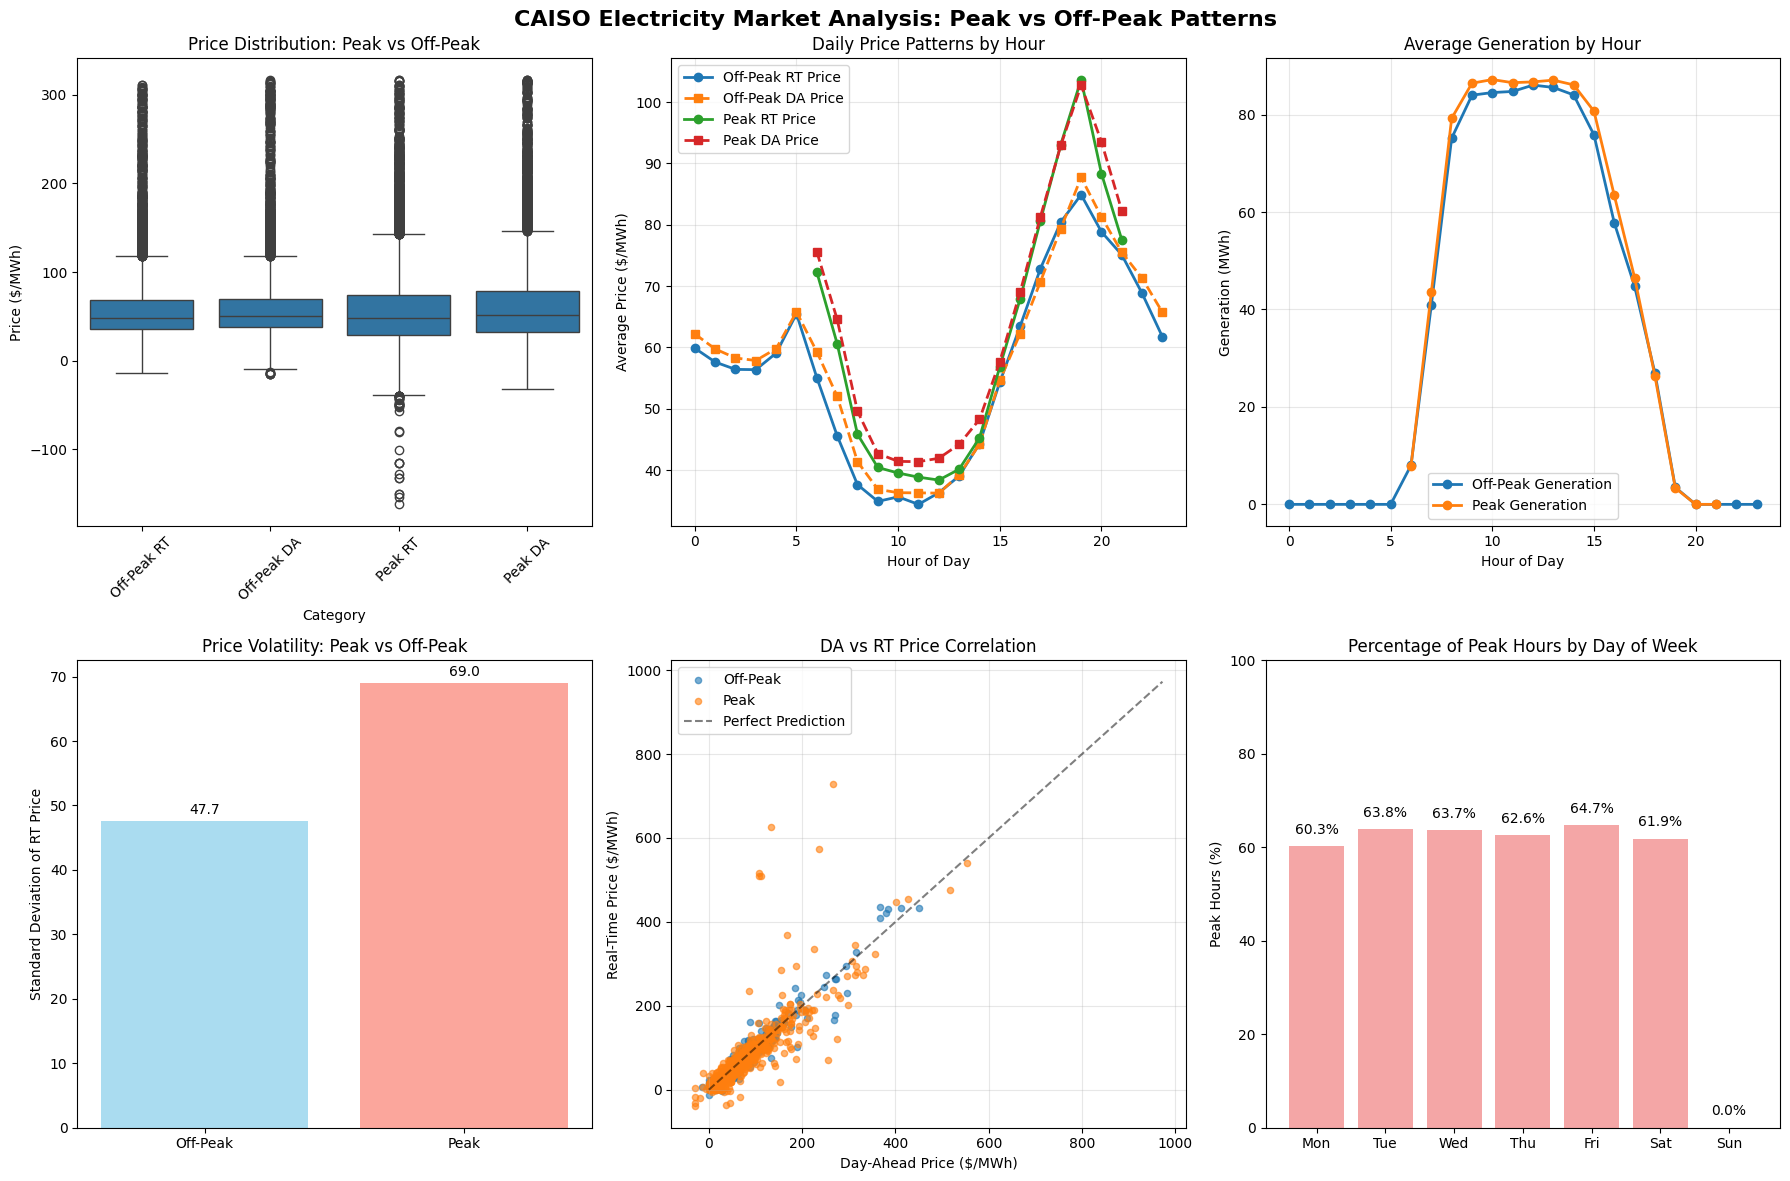


SUMMARY STATISTICS: PEAK VS OFF-PEAK ANALYSIS

Peak vs Off-Peak Summary Statistics:
------------------------------------------------------------
     RT Busbar                        DA Busbar           Gen
          mean    std     min     max      mean    std   mean
P/OP                                                         
0        60.21  47.66  -13.44  870.57     62.01  47.14   8.94
1        63.76  69.05 -162.04  972.45     66.23  61.26  51.09


Arbitrage Opportunities (RT - DA Spread):
------------------------------------------------------------
      mean    std
P/OP             
0    -1.80  16.21
1    -2.47  36.99


Peak Hour Analysis:
------------------------------------------------------------
Average Peak Hour Price: $63.76/MWh
Average Off-Peak Hour Price: $60.21/MWh
Peak Premium: $3.55/MWh
Peak/Off-Peak Ratio: 1.06x


Peak Hour Timing:
------------------------------------------------------------
Hours with highest percentage of peak pricing:
  Hour 10: 88.4% peak hours
 

In [7]:
visulaize_data("../data/CAISO-Historical-Data.csv", "CAISO")

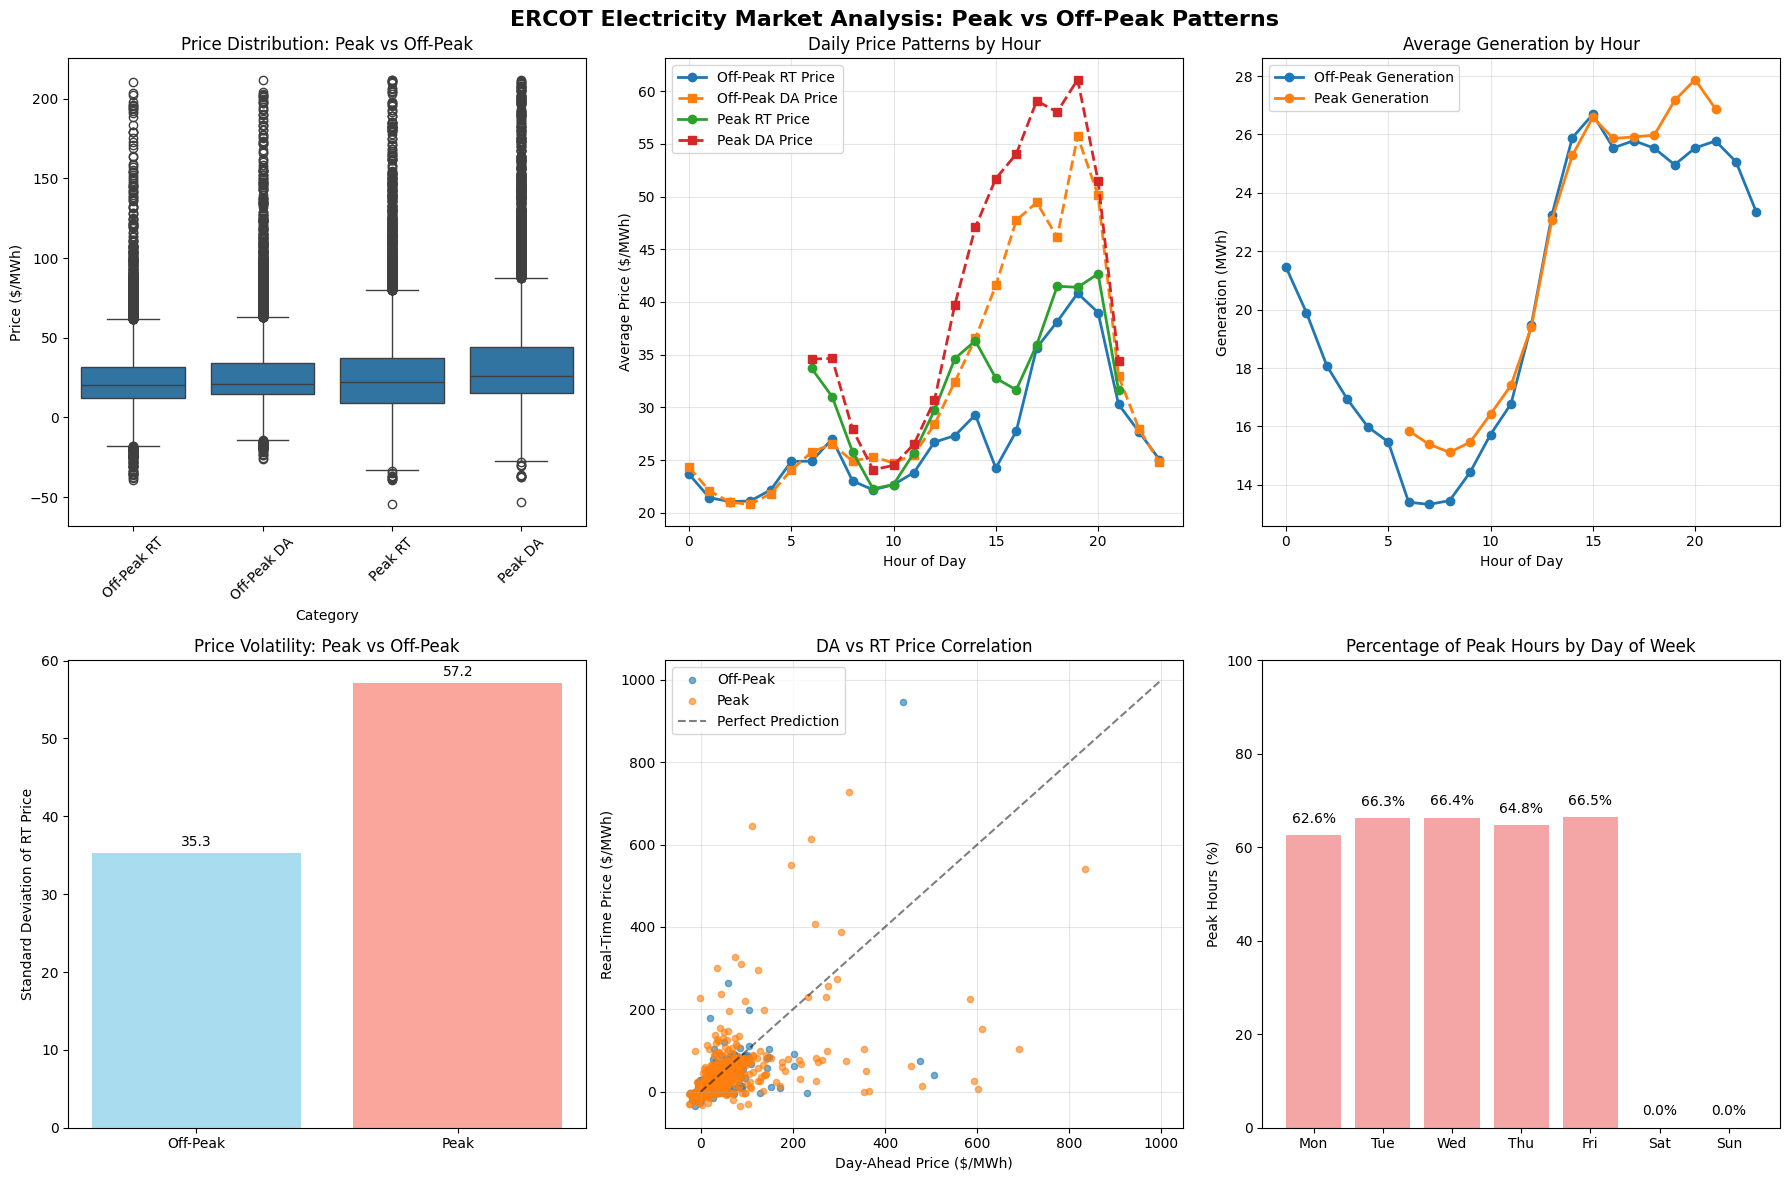


SUMMARY STATISTICS: PEAK VS OFF-PEAK ANALYSIS

Peak vs Off-Peak Summary Statistics:
------------------------------------------------------------
     RT Busbar                       DA Busbar           Gen
          mean    std    min     max      mean    std   mean
P/OP                                                        
0        25.50  35.33 -39.32  945.30     28.08  39.16  20.09
1        32.45  57.16 -54.58  979.26     41.17  66.89  21.83


Arbitrage Opportunities (RT - DA Spread):
------------------------------------------------------------
      mean    std
P/OP             
0    -2.58  39.07
1    -8.72  62.73


Peak Hour Analysis:
------------------------------------------------------------
Average Peak Hour Price: $32.45/MWh
Average Off-Peak Hour Price: $25.50/MWh
Peak Premium: $6.95/MWh
Peak/Off-Peak Ratio: 1.27x


Peak Hour Timing:
------------------------------------------------------------
Hours with highest percentage of peak pricing:
  Hour  9: 70.6% peak hours
  Hour

In [8]:
visulaize_data("../data/ERCOT-Historical-Data.csv", "ERCOT")

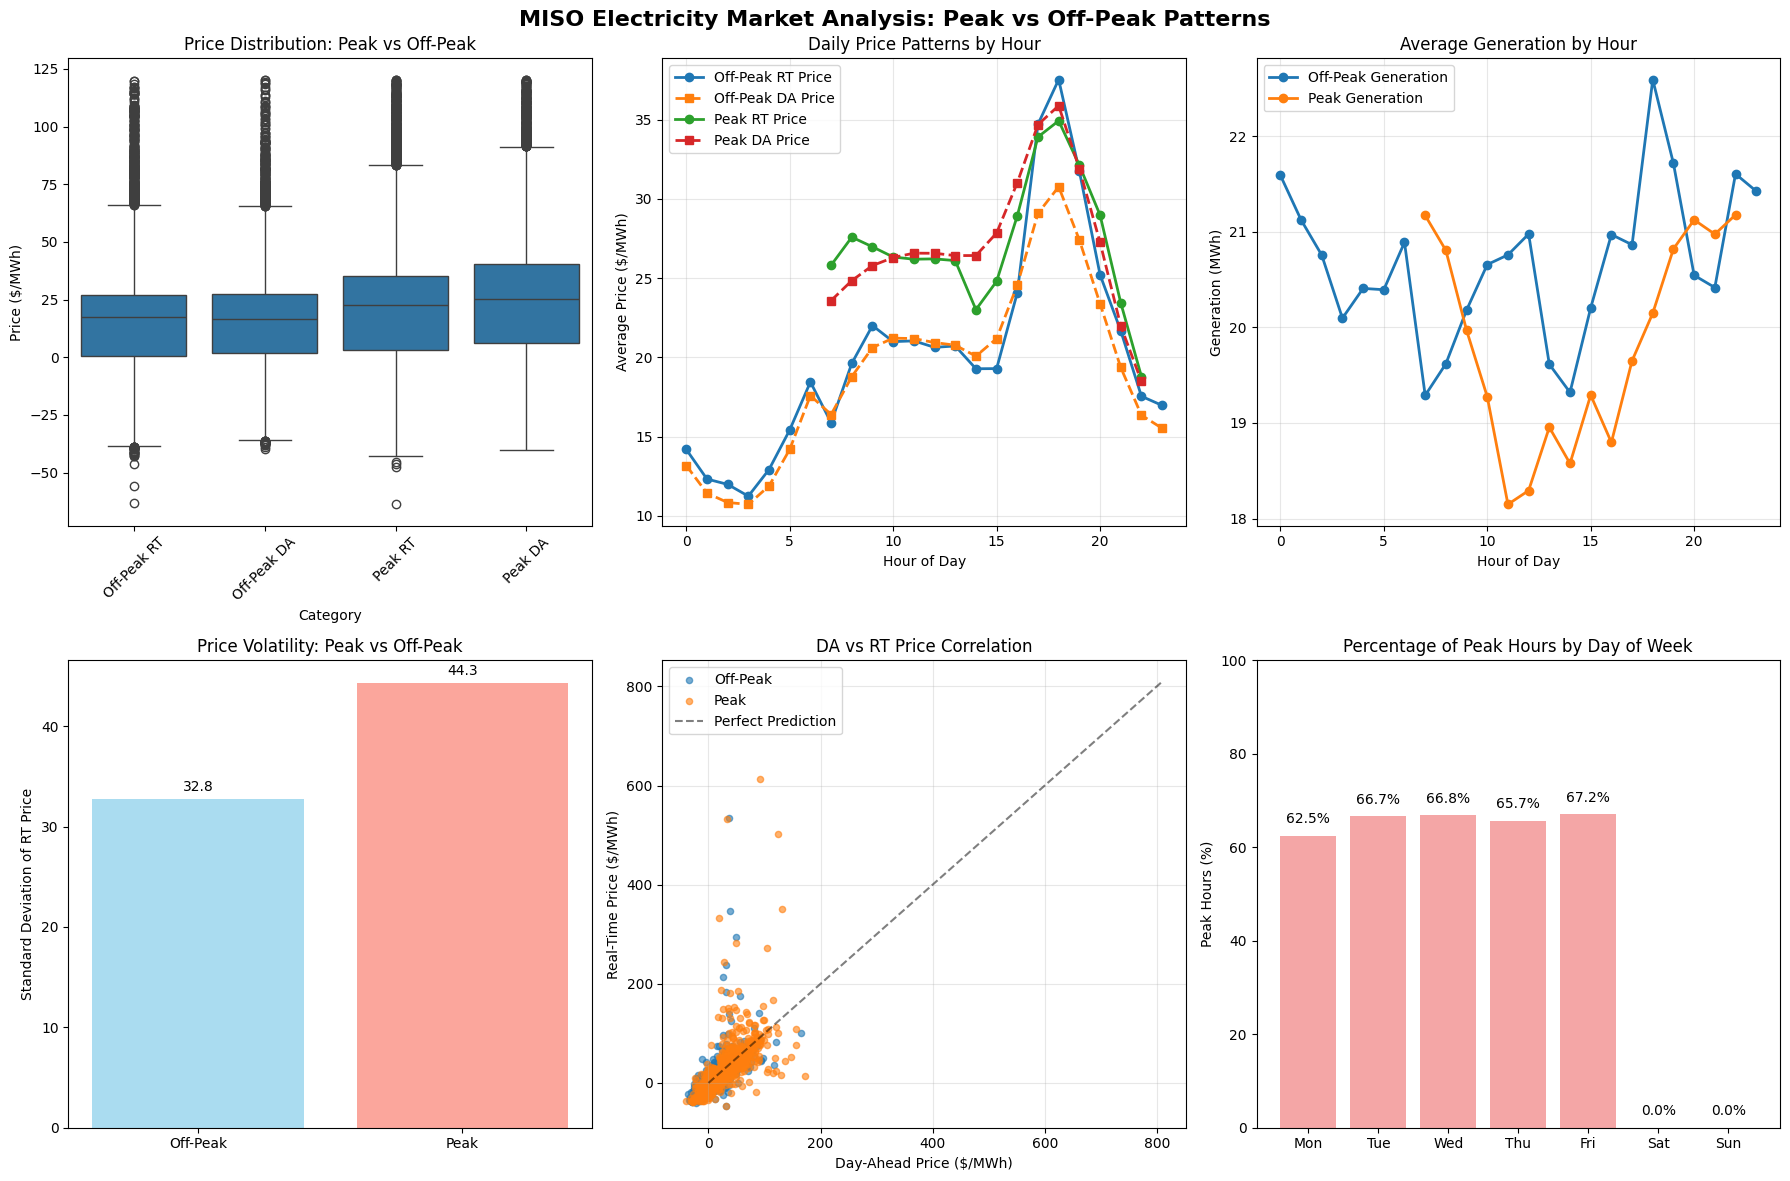


SUMMARY STATISTICS: PEAK VS OFF-PEAK ANALYSIS

Peak vs Off-Peak Summary Statistics:
------------------------------------------------------------
     RT Busbar                       DA Busbar           Gen
          mean    std    min     max      mean    std   mean
P/OP                                                        
0        17.69  32.77 -63.38  809.48     16.58  21.21  20.74
1        27.15  44.33 -63.78  789.69     27.23  29.04  19.83


Arbitrage Opportunities (RT - DA Spread):
------------------------------------------------------------
      mean    std
P/OP             
0     1.11  24.85
1    -0.08  34.80


Peak Hour Analysis:
------------------------------------------------------------
Average Peak Hour Price: $27.15/MWh
Average Off-Peak Hour Price: $17.69/MWh
Peak Premium: $9.45/MWh
Peak/Off-Peak Ratio: 1.53x


Peak Hour Timing:
------------------------------------------------------------
Hours with highest percentage of peak pricing:
  Hour 13: 70.5% peak hours
  Hour

In [9]:
visulaize_data("../data/MISO-Historical-Data.csv", "MISO")